In [1]:
!pip install jcopml

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

## Import Data

In [11]:
df = pd.read_csv("data/carprice.csv", index_col="ID")
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


## Quick EDA

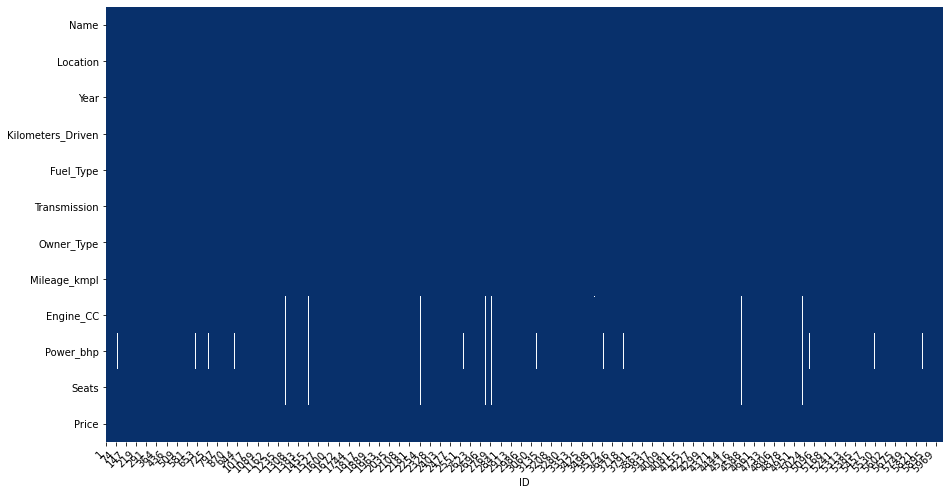

In [12]:
plot_missing_value(df)

In [13]:
df.drop(columns="Name", inplace=True)

In [14]:
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


In [16]:
X = df.drop(columns="Price")
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4762, 10), (1191, 10), (4762,), (1191,))

## Training

In [17]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [18]:
X_train.columns

Index(['Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
       'Owner_Type', 'Mileage_kmpl', 'Engine_CC', 'Power_bhp', 'Seats'],
      dtype='object')

In [22]:
X_train.Seats.value_counts()

5.0     3946
7.0      545
8.0      111
4.0       74
6.0       28
2.0       15
10.0       4
9.0        3
Name: Seats, dtype: int64

In [25]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params , cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   35.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 10.0, 'algo__gamma': 0.001}
0.41920496255096307 0.08721195017023531 0.05584995655861136


hasilnya jelek, karena svm alhoritma berdasarkan jarak seperti knn, maka kita scaling terlebih dahulu

In [26]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params , cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   21.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.8630526037720836 0.8299975600176358 0.8273628393685193


## setelah di scalling hasilnya jauh lebih bagus

## Polynomial Features

In [27]:
from luwiji.svm import demo

In [28]:
demo.poly_features()

interactive(children=(ToggleButtons(description='degree', options=(1, 2, 3), value=1), Checkbox(value=False, d…

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, scaling='standard'), ["Year", "Kilometers_Driven", "Mileage_kmpl", "Engine_CC", "Power_bhp", "Seats"]),
    ('categoric', cat_pipe(encoder='onehot'), ["Location", "Fuel_Type", "Transmission", "Transmission", "Owner_Type"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_poly_params , cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:  3.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 10.0, 'algo__gamma': 0.1, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.8630526037720794 0.8299975600176365 0.8273628393685127
